In [1]:
from myutils.nerdssData import Reaction_Name, _Reaction_nerdss, Write_Inp, Write_CrdInp
from myutils import utils, theory
import numpy as np
from myutils.nerdssData import nerdssData
from myutils.utils import find_equi_linear
from matplotlib import pyplot as plt
from pathlib import Path

# define functions

In [2]:
def notInNucleosomes(crd, nucCrds, nucSizes):
    for i in range(len(nucCrds)):
        if abs(crd - nucCrds[i]) <= nucSizes[i]:
            return False
    return True

def generate_N_crd(N_nonspec, xlim, y=0, z=0):
    NCrds = np.random.rand(N_nonspec)*(xlim[1]-xlim[0])+xlim[0]
    return [[x, y, z] for x in NCrds]

def generate_P_crd(Np, xlim, y, z, sigma):
    aveDistance = (xlim[1]-xlim[0])/(Np+1)
    pCrds = []
    for i in range(Np):
        if i%2 == 0:
            pCrds.append([ xlim[0] + (i+1)*aveDistance, y, z])
        else:
            pCrds.append([ xlim[0] + (i-1+1)*aveDistance+sigma, y, z])
                
    return pCrds

In [3]:
def onRate_macro2micro(ka_macro, D, sigma):
        if ka_macro < 1e-10:
            return 0
        else:
            return (1/ka_macro - 1/(4*np.pi*D*sigma))**-1

def get_static_Parms(
    kbPFixed=0.4, DP3D=1.5, DN1D=1.0, PPsigma=1.4, 
    lengthScale=50, dt=1, area3Dto1D=10, 
    kaPS_macro = 1000, kaPN_macro = 200
):
    
    C0 = 0.6022

    DP1D = (1/DP3D + 1/DN1D)**(-1)
    konMax = (4*np.pi*(2*DP3D)*PPsigma)
    print('DP1D: %.3f\tKonD3d: %.3f\tKPPmax (M^-1): %.1e'%(DP1D, konMax, konMax/(kbPFixed*1e-6)*C0))
    kaPS = onRate_macro2micro(kaPS_macro*1e-6, DP3D, 1)
    kaPN = onRate_macro2micro(kaPN_macro*1e-6, DP3D, 1)

    Rmax = PPsigma + 3 * np.sqrt( 6*DP3D*2 * dt )
    
    passed = True
    if Rmax > WaterBox[0]/2:
        print(f'Diffusion per step too large to stay in waterbox.x: Rmax={Rmax:.1f}, x/2={WaterBox[0]/2:.1f}')
        passed = True
    if Rmax > WaterBox[1]/2:
        print(f'Diffusion per step too large to stay in waterbox.y: Rmax={Rmax:.1f}, x/2={WaterBox[1]/2:.1f}')
        passed = True
    if Rmax > WaterBox[2]/2:
        print(f'Diffusion per step too large to stay in waterbox.z: Rmax={Rmax:.1f}, x/2={WaterBox[2]/2:.1f}')
        passed = True
    if passed:
        print('Diffusion and time step fit in waterbox.')
        
    L = lengthScale*21/2 - PPsigma # nm
    Diff = DP1D* 2 # nm^2/us
    onRateDiff = (L/3/Diff)**(-1)
    print(f'(L/(3D))^(-1) = {onRateDiff:.1e} nm/us')
    
    return kaPS, kaPN

# first try

## set input

In [5]:
def writeInputs(
    nItr, timeStep=1, timeWrite=1e5, pdbWrite=1e2, trajWrite=1e5,
    WaterBox=[100,100,100], molecules = {'P':[[],[]], 'N':[1, 2, 3, 4, 5]},
    kaPS=0, kbPS=0, KPS=0, kaPN=0, kbPN=0, KPN=0, kaPP=0, kbPP=0, KPP=0
):
    """
    All timescale parameters are assumed integers (x.0f).
    """
    
    def _writeSientificInteger(x):
        if x == 0:
            return '0'
        elif np.isinf(x):
            return 'inf'
        else:
            magnitude = 0
            while x%(10**magnitude) == 0:
                magnitude += 1
            remain = x/(10**(magnitude-1))
            return '%de%.0f'%(remain, magnitude-1)
    
    parmFile = f'''# Info:
#    
#
# 
# 

start parameters
    nItr = {int(nItr+1)} #iterations
    timeStep = {_writeSientificInteger(timeStep)} # us, the maximum timestep calculated from kbPN
    timeWrite = {_writeSientificInteger(timeWrite)}
    pdbWrite = {_writeSientificInteger(pdbWrite)}
    trajWrite = {_writeSientificInteger(trajWrite)}
    assocdissocwrite = true
    overlapSepLimit = 1.0
end parameters

start boundaries
    WaterBox = {WaterBox} # VtoL=4000
end boundaries

start molecules
'''+\
'\n'.join(['    '+key+' : '+str(len(molecules[key])) for key in molecules if len(molecules[key])>0])\
+f'''
end molecules

start reactions

    # N(ref) + nuc(ref) -> N(ref!1).nuc(ref!1)
    # onRate3Dka = 0
    # offRatekb = 0
    # norm1 = [0, 0, 1]
    # norm2 = [0, 0, 1]
    # sigma = 5.5
    # assocAngles = [nan, nan, nan, nan, nan]
    # loopcoopfactor = 1
    # bindRadSameCom = 1.1

    # P(ref) + nuc(ref) -> P(ref!1).nuc(ref!1)
    # onRate3Dka = 0
    # offRatekb = 0
    # norm1 = [0, 0, 1]
    # norm2 = [0, 0, 1]
    # sigma = 5.5
    # assocAngles = [nan, nan, nan, nan, nan]
    # loopcoopfactor = 1
    # bindRadSameCom = 1.1    

    S(re1) + S(re2) -> S(re1!1).S(re2!1)
    onRate3Dka = 1e6
    norm1 = [0, 0, 1]
    norm2 = [0, 0, 1]
    sigma = 1.8001
    assocAngles = [M_PI, M_PI, nan, nan, 0.000000]
    loopcoopfactor = 1
    bindRadSameCom = 1.00001

    S(bs) + P(dbs) <-> S(bs!1).P(dbs!1)
    onRate3Dka = {kaPS}
    offRatekb = {kbPS} # Keq = {_writeSientificInteger(1e3*KPN*C0)}
    norm1 = [0, 0, 1]
    norm2 = [0, 0, 1]
    sigma = 1.00
    assocAngles = [0.785398, 2.356194, 0.000000, M_PI, 0.000000]
    loopcoopfactor = 1
    bindRadSameCom = 1.1
    area3dto1d = 10

    N(bs) + P(dbn) <-> N(bs!1).P(dbn!1)
    onRate3Dka = 1e6 # {kaPN}
    offRatekb = 0 # {kbPN} # Keq = {_writeSientificInteger(KPN*C0)}
    norm1 = [0, 0, 1]
    norm2 = [0, 0, 1]
    sigma = 1.000007
    assocAngles = [0.785398, 2.356194, 0.000000, M_PI, 0.000000]
    loopcoopfactor = 1
    bindRadSameCom = 1.1
    area3dto1d = 10
    
    # P(pp1) + P(pp2) <-> P(pp1!1).P(pp2!1)
    # onRate3Dka = {kaPP} 
    # offRatekb = {kbPP} # Keq = {_writeSientificInteger(KPP*C0)}
    # norm1 = [0, 0, 1]
    # norm2 = [0, 0, 1]
    # sigma = 0.6
    # assocAngles = [2.86329, 2.86329, -1.5708, 1.5708, 0.000000]
    # loopcoopfactor = 1
    # bindRadSameCom = 1.1
    # area3dto1d = 10
    
    P(pp0) + P(pp0) <-> P(pp0!1).P(pp0!1)
    onRate3Dka = {kaPP} 
    offRatekb = {kbPP} # Keq = {_writeSientificInteger(KPP*C0)}
    norm1 = [0, 0, 1]
    norm2 = [0, 0, 1]
    sigma = 2
    assocAngles = [1.570796, 1.570796, -1.570796, 1.570796, 0.000000]
    loopcoopfactor = 1
    bindRadSameCom = 1.1
    area3dto1d = 1

end reactions
'''
    return parmFile

def generateCoords(WaterBox, excLength, Ninfo, Sxyz, nucxyz, Pnum=None, Pxyz=None):
    '''
    WaterBox: x, y, z length in nm
    excLength: half size of nucleosome in nm
    Sxyz: x coordinate, y and z ratio compared to the waterbox
    Ninfo: [number, xRangeRatio, yRatio, zRatio]
    nucyz: x, y and z ratio compared to the waterbox
    Pnum: number of proteins
    Pxyz: x coordinate, y and z ratio compared to the waterbox
    '''
    coordinates = {'S':[], 'N':[], 'nuc':[], 'P':[]}
    # manualy set the positions of targets
    for row in Sxyz:
        coordinates['S'].append([
            row[0], row[1]*WaterBox[1], row[2]*WaterBox[2]
        ])
    # automatically calculate the N crds and nuc crds
    NCrds = []
    for row in Ninfo:
        xRange = [WaterBox[0]*min(row[1])+excLength, WaterBox[0]*max(row[1])-excLength]
        NCrds.append(generate_N_crd(
            row[0], xRange, y=row[2]*WaterBox[1], z=row[3]*WaterBox[2]
        ))
    coordinates['N'] = np.concatenate(NCrds)
    for row in nucxyz:
        coordinates['nuc'].append([
            row[0]*WaterBox[0], row[1]*WaterBox[1], row[2]*WaterBox[2]
        ])
    if (Pnum==None) and (Pxyz==None):
        raise ValueError('One of Pnum and Pxyz should not be empty.')
    elif (Pnum != None):
        for i in range(Pnum):
            coordinates['P'].append([])
    else:
        for row in Pxyz:
            coordinates['P'].append([
                row[0], row[1]*WaterBox[1], row[2]*WaterBox[2]
            ])
    return coordinates

In [6]:
lengthScale = 2
WaterBox = [200, 31.623*2, 31.623*2]
excLength = 0
kbPFixed = 10 #0.4
ppSigma = 1.4
DP3D = 1.5

# manualy set the positions of targets
yzRatio = 1/4
fixCoords = generateCoords(
    WaterBox, excLength, 
    Ninfo=[
        [int(12/21*WaterBox[0] - 1), [-1/2, 1/2], yzRatio, yzRatio], 
        [int(12/21*WaterBox[0] - 2), [-1/2, 1/2], -yzRatio, yzRatio],
        [int(12/21*WaterBox[0] - 3), [-1/2, 1/2], yzRatio, -yzRatio],
        [int(12/21*WaterBox[0] - 4), [-1/2, 1/2], -yzRatio, -yzRatio]
    ],
    Sxyz=[
        [0, yzRatio, yzRatio], 
        [-1, -yzRatio, yzRatio], [1, -yzRatio, yzRatio],
        [-2, yzRatio, -yzRatio], [0, yzRatio, -yzRatio], [2, yzRatio, -yzRatio], 
        [-3, -yzRatio, -yzRatio], [-1, -yzRatio, -yzRatio], [1, -yzRatio, -yzRatio], [3, -yzRatio, -yzRatio], 
    ],
    nucxyz=[],
    Pnum=2,
)
# calculate fixed parameters
kaPS, kaPN = get_static_Parms(
    kbPFixed, PPsigma=ppSigma, DP3D=DP3D, kaPN_macro=20000, kaPS_macro=100000
)

DP1D: 0.600	KonD3d: 52.779	KPPmax (M^-1): 3.2e+06
Diffusion and time step fit in waterbox.
(L/(3D))^(-1) = 6.9e-03 nm/us


In [7]:
def _getkakbPP(KPP, kbPFixed):
    if KPP == 0:
        kbPP = 0
        kaPP = 0
    else:
        kbPP = kbPFixed
        kaPP = onRate_macro2micro(KPP*kbPP*1e-6, 2*DP3D, ppSigma)
        kbPP = kaPP / KPP * 1e6
    return kaPP, kbPP 

def _getDirName(pfolder, KPN, KPP, rn):
    C0 = 0.6022
    if KPP == 0:
        namedir = f'{pfolder}/{rn}/'
    else:
        namedir = f'{pfolder}/{rn}/'
    return namedir

C0 = 0.6022
equi_parms = [
    [10/C0, 1e4/C0], #
] # M^-1 -> nm^3

N_repeat = 0
accBind = 1 # accelarate binding to relax from bound state
pfolder = './test/demo/'

for KPN, KPP in equi_parms:
    KPS = KPN*1e3
    kbPS = kaPS*1e6 / KPS
    kbPN = kaPN*1e6 / KPN
    kaPP, kbPP = _getkakbPP(KPP, kbPFixed)
    print('kaP: %.2e'%kaPP, 'kbP: %.2e'%kbPP, 'kbN: %.2e'%kbPN, 'kbS: %.2e'%kbPS)
    
#     for rn in range(N_repeat):
#         namedir = _getDirName(pfolder, KPN, KPP, rn)

    namedir = pfolder
    parmFile = writeInputs(
        nItr=1e4, timeStep=1, timeWrite=1e3, pdbWrite=1e4, trajWrite=1e6,
        WaterBox=WaterBox, molecules = fixCoords,
        kaPS=kaPS, kbPS=kbPS, KPS=KPS, kaPN=kaPN, 
        kbPN=kbPN, KPN=KPN, kaPP=kaPP, kbPP=kbPP, KPP=KPP,
    )
    # create directory and write parameters
    Path(namedir).mkdir(parents=True, exist_ok=True)
    with open(f'./{namedir}/parms.inp', 'w') as f:
        f.write(parmFile)
    # write coordinates
    crdFileName = f'./{namedir}/fixCoordinates.inp'
    Write_CrdInp(crdFileName, fixCoords, WaterBox)

kaP: 1.67e-01 kbP: 1.00e+01 kbN: 1.21e+03 kbS: 6.05e+00


## analyze

In [98]:
selectedTraj = [0,2,5,6,7,8,9,10,13,14,15,16,17,18,20,22,23,24,25,26,27]

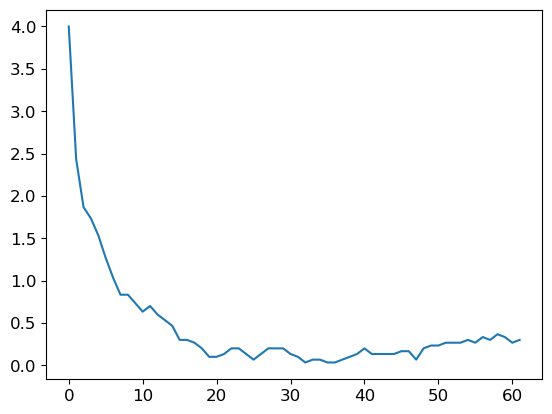

In [97]:
nd = nerdssData(30, './twoDimers/', ifprint=False)
nd.readHist('DATA/histogram_complexes_time.dat', ifprint=False)

plt.plot(nd.time, nd.MOLS['P: 1.'])


In [98]:
class PDB_NERDSS():
    
    def __init__(self, parentDir='', pdbWrite=1e5):
        self._pdir = parentDir
        self._pdbStep = pdbWrite
        self.t = []
        self.x = []
        self.proteinNumbers = []
        self.regions = []
        self.t_longest = []

    
    def read_pdbs(
        self, N_repeat=None, pdbInitial=1e6, pdbMin=0, pdbMax=np.inf, 
        YZcenterList=[], chromRadius=5.5,
        timeStep:float=1e-6
    ):
        '''Read pdbs untill pdbMax
        
        Args:
        
            N_repeat (int, iterable): 
                (int) the number of repeats, will read subfolders named in `range(N_repeat)`
                (iterable of strings) the names of subfolders
            
            pdbMin (int): The min index (number of steps) of pdb read.
            
            pdbMax (int): The max index (number of steps) of pdb read.
            
            YZcenter (float): The center coordinate of Y and Z axes (they are the same) used to calculate r.
            
            timeStep (float): time jump for one step.
            
        Returns:
            None: 
                self.x (list of lists): x coordinates
                self.r (list of lists): r distances
                self.t (list of lists): time points
                self.t_longest (list): the longest time points
        '''
        
        self._pdbMax = pdbMax
        self._YZcenterList = YZcenterList
        self.regions = [[] for i in YZcenterList] + [[]]
        self._tStep = timeStep
        
        if N_repeat is None:
            self._subnames = ['']
        elif isinstance(N_repeat, int):
            self._subnames = [str(i) for i in range(N_repeat)]
        else: # assume it is iterable
            self._subnames = [str(i) for i in N_repeat]
        self._Nrepeats = len(self._subnames)
        
        for subname in self._subnames:
            x = []
            t = []
            NItr = pdbMin # include the initial coordinates
            while NItr < self._pdbMax:
                # in case the simulation does not run through pdbMax*pdbStep
                filename = int(NItr*self._pdbStep+pdbInitial)
                x_itr = []
                try:
                    with open(f'{self._pdir}/{subname}/PDB/{filename}.pdb') as f:
                        for line in f:
                            linelist = line.split()
                            if linelist[2] == 'COM' and linelist[3] == 'P':
                                CRDx = float(linelist[5])
                                CRDy = float(linelist[6])
                                CRDz = float(linelist[7])
                                onDNA = False
                                for iyz, (yCenter, zCenter) in enumerate(self._YZcenterList):
                                    if ((CRDy-yCenter)**2 + (CRDz-zCenter)**2)**0.5 < chromRadius:
                                        self.regions[iyz].append(CRDx)
                                        onDNA = True
                                        break
                                if not onDNA:
                                    self.regions[-1].append(CRDx)
                    t.append(NItr*self._pdbStep*self._tStep)
                    NItr += 1
                except:
                    break

            self.x.append(x)
            self.t.append(t)
        
        self._subnames = [name for i, name in enumerate(self._subnames) if len(self.t[i]) != 0]
        self._Nrepeats = len(self._subnames)
        self.x = [x for i, x in enumerate(self.x) if len(self.t[i]) != 0]
        self.t = [t for t in self.t if len(t)!=0]
                
        
        self.t_longest = self.t[0]
        for t in self.t:
            if len(t) > len(self.t_longest):
                self.t_longest = t
            
    def get_all_x(self, burnInSteps=1):
        '''collect all x coordinates of proteins
        
        Args:
            burnInSteps (int): The min number of pdbs considered. Use this to exclude burn-in steps.
            
        Returns:
            self.x_all (list): The x coordinates of proteins
        '''
        
        self._pdbNumMin = burnInSteps
        self.x_all = []
        
        for nr in range(0, self._Nrepeats):
            self.x_all += [x for x in self.x[nr][self._pdbNumMin:]]
        
        return self.x_all
        

In [107]:
yzCrd = 31.623/2
PDB = PDB_NERDSS(f'./twoDimers/', pdbWrite=6e7)
PDB.read_pdbs(
    N_repeat=30, timeStep=1e-6, pdbInitial=2e7, pdbMin=0,
    YZcenterList=[[yzCrd,yzCrd], [3*yzCrd,yzCrd], [yzCrd,3*yzCrd], [3*yzCrd,3*yzCrd]]
)

412 [181, 139, 79, 0, 13] [0.4393203883495146, 0.33737864077669905, 0.19174757281553398, 0.0, 0.03155339805825243]


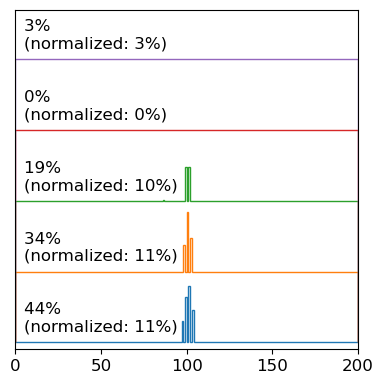

In [108]:
totProtein = np.sum([len(r) for r in PDB.regions])
print(totProtein, [len(r) for r in PDB.regions], [len(r)/totProtein for r in PDB.regions])
normalization = [4, 3, 2, 1, 1]

stepSize = 0.2

plt.rcParams['font.size']=12
plt.figure(figsize=(4,4))
for ir, r in enumerate(PDB.regions):
    hist, bin_edges = np.histogram(r, bins=np.arange(0,201,1))
    plt.stairs(hist/totProtein + stepSize*ir, bin_edges)
    plt.text(5, stepSize*ir+0.03, '%.0f%% \n(normalized: %.0f%%)'%(100*len(r)/totProtein, 
                                           100*len(r)/totProtein/normalization[ir]))
plt.xlim([0,200])
# plt.yticks(
#     np.array([0,1,2,3,4])*stepSize,
#     ['4 Targets', '3 Targets', '2 Targets', '1 Targets', 'In solution'],
# )
plt.yticks([])
plt.ylim([-stepSize*0.1, 4*stepSize+stepSize*0.7])
plt.tight_layout()
plt.show()

# 4 in a row

## define functions and set input

In [4]:
def writeInputs(
    nItr, timeStep=1, timeWrite=1e5, pdbWrite=1e2, trajWrite=1e5,
    WaterBox=[100,100,100], molecules = {'P':[[],[]], 'N':[1, 2, 3, 4, 5]},
    kaPS=0, kbPS=0, KPS=0, kaPN=0, kbPN=0, KPN=0, kaPP=0, kbPP=0, KPP=0
):
    """
    All timescale parameters are assumed integers (x.0f).
    """
    
    def _writeSientificInteger(x):
        if x == 0:
            return '0'
        elif np.isinf(x):
            return 'inf'
        else:
            magnitude = 0
            while x%(10**magnitude) == 0:
                magnitude += 1
            remain = x/(10**(magnitude-1))
            return '%de%.0f'%(remain, magnitude-1)
    
    parmFile = f'''# Info:
#    
#
# 
# 

start parameters
    nItr = {int(nItr+1)} #iterations
    timeStep = {_writeSientificInteger(timeStep)} # us, the maximum timestep calculated from kbPN
    timeWrite = {_writeSientificInteger(timeWrite)}
    pdbWrite = {_writeSientificInteger(pdbWrite)}
    trajWrite = {_writeSientificInteger(trajWrite)}
    assocdissocwrite = true
    overlapSepLimit = 1.0
end parameters

start boundaries
    WaterBox = {WaterBox} # VtoL=4000
end boundaries

start molecules
'''+\
'\n'.join(['    '+key+' : '+str(len(molecules[key])) for key in molecules if len(molecules[key])>0])\
+f'''
end molecules

start reactions

    N(ref) + nuc(ref) -> N(ref!1).nuc(ref!1)
    onRate3Dka = 0
    offRatekb = 0
    norm1 = [0, 0, 1]
    norm2 = [0, 0, 1]
    sigma = 5.5
    assocAngles = [nan, nan, nan, nan, nan]
    loopcoopfactor = 1
    bindRadSameCom = 1.1

    P(ref) + nuc(ref) -> P(ref!1).nuc(ref!1)
    onRate3Dka = 0
    offRatekb = 0
    norm1 = [0, 0, 1]
    norm2 = [0, 0, 1]
    sigma = 5.5
    assocAngles = [nan, nan, nan, nan, nan]
    loopcoopfactor = 1
    bindRadSameCom = 1.1    

    S(re1) + S(re2) -> S(re1!1).S(re2!1)
    onRate3Dka = 1e6
    norm1 = [0, 0, 1]
    norm2 = [0, 0, 1]
    sigma = 1.8001
    assocAngles = [M_PI, M_PI, nan, nan, 0.000000]
    loopcoopfactor = 1
    bindRadSameCom = 1.00001

    S(bs) + P(dbs) <-> S(bs!1).P(dbs!1)
    onRate3Dka = {kaPS}
    offRatekb = {kbPS} # Keq = {_writeSientificInteger(1e3*KPN*C0)}
    norm1 = [0, 0, 1]
    norm2 = [0, 0, 1]
    sigma = 1.00
    assocAngles = [0.785398, 2.356194, 0.000000, M_PI, 0.000000]
    loopcoopfactor = 1
    bindRadSameCom = 1.1
    area3dto1d = 10

    N(bs) + P(dbn) <-> N(bs!1).P(dbn!1)
    onRate3Dka = {kaPN}
    offRatekb = {kbPN} # Keq = {_writeSientificInteger(KPN*C0)}
    norm1 = [0, 0, 1]
    norm2 = [0, 0, 1]
    sigma = 1.000007
    assocAngles = [0.785398, 2.356194, 0.000000, M_PI, 0.000000]
    loopcoopfactor = 1
    bindRadSameCom = 1.1
    area3dto1d = 10
    
    P(pp1) + P(pp2) <-> P(pp1!1).P(pp2!1)
    onRate3Dka = {kaPP} 
    offRatekb = {kbPP} # Keq = {_writeSientificInteger(KPP*C0)}
    norm1 = [0, 0, 1]
    norm2 = [0, 0, 1]
    sigma = 0.6
    assocAngles = [2.86329, 2.86329, -1.5708, 1.5708, 0.000000]
    loopcoopfactor = 1
    bindRadSameCom = 1.1
    area3dto1d = 10
    
    # P(pp0) + P(pp0) <-> P(pp0!1).P(pp0!1)
    # onRate3Dka = {kaPP} 
    # offRatekb = {kbPP} # Keq = {_writeSientificInteger(KPP*C0)}
    # norm1 = [0, 0, 1]
    # norm2 = [0, 0, 1]
    # sigma = 2
    # assocAngles = [1.570796, 1.570796, -1.570796, 1.570796, 0.000000]
    # loopcoopfactor = 1
    # bindRadSameCom = 1.1
    # area3dto1d = 1

end reactions
'''
    return parmFile

def generateCoords(WaterBox, excLength, Ninfo, Sxyz, nucxyz, Pnum=None, Pxyz=None):
    '''
    WaterBox: x, y, z length in nm
    excLength: half size of nucleosome in nm
    Sxyz: x coordinate, y and z ratio compared to the waterbox
    Ninfo: [number, xRangeRatio, yRatio, zRatio]
    nucyz: x, y and z ratio compared to the waterbox
    Pnum: number of proteins
    Pxyz: x coordinate, y and z ratio compared to the waterbox
    '''
    coordinates = {'S':[], 'N':[], 'nuc':[], 'P':[]}
    # manualy set the positions of targets
    for row in Sxyz:
        coordinates['S'].append([
            row[0], row[1]*WaterBox[1], row[2]*WaterBox[2]
        ])
    # automatically calculate the N crds and nuc crds
    NCrds = []
    for row in Ninfo:
        xRange = [WaterBox[0]*min(row[1])+excLength, WaterBox[0]*max(row[1])-excLength]
        NCrds.append(generate_N_crd(
            row[0], xRange, y=row[2]*WaterBox[1], z=row[3]*WaterBox[2]
        ))
    coordinates['N'] = np.concatenate(NCrds)
    for row in nucxyz:
        coordinates['nuc'].append([
            row[0]*WaterBox[0], row[1]*WaterBox[1], row[2]*WaterBox[2]
        ])
    if (Pnum==None) and (Pxyz==None):
        raise ValueError('One of Pnum and Pxyz should not be empty.')
    elif (Pnum != None):
        for i in range(Pnum):
            coordinates['P'].append([])
    else:
        for row in Pxyz:
            coordinates['P'].append([
                row[0], row[1]*WaterBox[1], row[2]*WaterBox[2]
            ])
    return coordinates

In [5]:
lengthScale = 2
WaterBox = [200, 31.623*2, 31.623*2]
excLength = 0
kbPFixed = 10 #0.4
ppSigma = 1.4
DP3D = 1.5

# manualy set the positions of targets
yzRatio = 1/4
fixCoords = generateCoords(
    WaterBox, excLength, 
    Ninfo=[
        [int(12/21*WaterBox[0] - 1), [-1/2, 1/2], yzRatio, yzRatio], 
        [int(12/21*WaterBox[0] - 2), [-1/2, 1/2], -yzRatio, yzRatio],
        [int(12/21*WaterBox[0] - 3), [-1/2, 1/2], yzRatio, -yzRatio],
        [int(12/21*WaterBox[0] - 4), [-1/2, 1/2], -yzRatio, -yzRatio]
    ],
    Sxyz=[
        [0, yzRatio, yzRatio], 
        [-1, -yzRatio, yzRatio], [1, -yzRatio, yzRatio],
        [-2, yzRatio, -yzRatio], [0, yzRatio, -yzRatio], [2, yzRatio, -yzRatio], 
        [-3, -yzRatio, -yzRatio], [-1, -yzRatio, -yzRatio], [1, -yzRatio, -yzRatio], [3, -yzRatio, -yzRatio], 
    ],
    nucxyz=[],
    Pnum=2,
)
# calculate fixed parameters
kaPS, kaPN = get_static_Parms(
    kbPFixed, PPsigma=ppSigma, DP3D=DP3D, kaPN_macro=20000, kaPS_macro=100000
)

DP1D: 0.600	KonD3d: 52.779	KPPmax (M^-1): 3.2e+06
Diffusion and time step fit in waterbox.
(L/(3D))^(-1) = 6.9e-03 nm/us


In [6]:
def _getkakbPP(KPP, kbPFixed):
    if KPP == 0:
        kbPP = 0
        kaPP = 0
    else:
        kbPP = kbPFixed
        kaPP = onRate_macro2micro(KPP*kbPP*1e-6, 2*DP3D, ppSigma)
        kbPP = kaPP / KPP * 1e6
    return kaPP, kbPP 

def _getDirName(pfolder, KPN, KPP, rn):
    C0 = 0.6022
    if KPP == 0:
        namedir = f'{pfolder}/{rn}/'
    else:
        namedir = f'{pfolder}/{rn}/'
    return namedir

C0 = 0.6022
equi_parms = [
    [10/C0, 1e4/C0], #
] # M^-1 -> nm^3

N_repeat = 0
accBind = 1 # accelarate binding to relax from bound state
pfolder = './test/fourInRow/'

for KPN, KPP in equi_parms:
    KPS = KPN*1e3
    kbPS = kaPS*1e6 / KPS
    kbPN = kaPN*1e6 / KPN
    kaPP, kbPP = _getkakbPP(KPP, kbPFixed)
    print('kaP: %.2e'%kaPP, 'kbP: %.2e'%kbPP, 'kbN: %.2e'%kbPN, 'kbS: %.2e'%kbPS)
    
#     for rn in range(N_repeat):
#         namedir = _getDirName(pfolder, KPN, KPP, rn)

    namedir = pfolder
    parmFile = writeInputs(
        nItr=1e4, timeStep=1, timeWrite=1e3, pdbWrite=1e4, trajWrite=1e6,
        WaterBox=WaterBox, molecules = fixCoords,
        kaPS=kaPS, kbPS=kbPS, KPS=KPS, kaPN=kaPN, 
        kbPN=kbPN, KPN=KPN, kaPP=kaPP, kbPP=kbPP, KPP=KPP,
    )
    # create directory and write parameters
    Path(namedir).mkdir(parents=True, exist_ok=True)
    with open(f'./{namedir}/parms.inp', 'w') as f:
        f.write(parmFile)
    # write coordinates
    crdFileName = f'./{namedir}/fixCoordinates.inp'
    Write_CrdInp(crdFileName, fixCoords, WaterBox)

kaP: 1.67e-01 kbP: 1.00e+01 kbN: 1.21e+03 kbS: 6.05e+00


## analyze

In [98]:
# selectedTraj = [0,2,5,6,7,8,9,10,13,14,15,16,17,18,20,22,23,24,25,26,27]

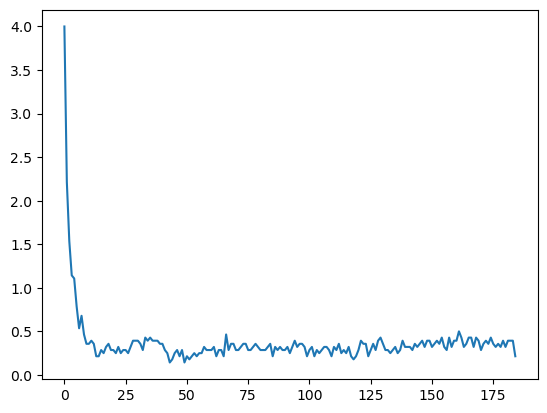

In [84]:
nd = nerdssData([i for i in range(30) if i not in [4,7]], './fourInRow/', ifprint=False)
nd.readHist('DATA/histogram_complexes_time.dat', ifprint=False)

plt.plot(nd.time, nd.MOLS['P: 1.'])


In [47]:
class PDB_NERDSS():
    
    def __init__(self, parentDir='', pdbWrite=1e5):
        self._pdir = parentDir
        self._pdbStep = pdbWrite
        self.t = []
        self.x = []
        self.proteinNumbers = []
        self.regions = []
        self.t_longest = []

    
    def read_pdbs(
        self, N_repeat=None, pdbInitial=1e6, pdbMin=0, pdbMax=np.inf, 
        YZcenterList=[], chromRadius=5.5,
        timeStep:float=1e-6
    ):
        '''Read pdbs untill pdbMax
        
        Args:
        
            N_repeat (int, iterable): 
                (int) the number of repeats, will read subfolders named in `range(N_repeat)`
                (iterable of strings) the names of subfolders
            
            pdbMin (int): The min index (number of steps) of pdb read.
            
            pdbMax (int): The max index (number of steps) of pdb read.
            
            YZcenter (float): The center coordinate of Y and Z axes (they are the same) used to calculate r.
            
            timeStep (float): time jump for one step.
            
        Returns:
            None: 
                self.x (list of lists): x coordinates
                self.r (list of lists): r distances
                self.t (list of lists): time points
                self.t_longest (list): the longest time points
        '''
        
        self._pdbMax = pdbMax
        self._YZcenterList = YZcenterList
        self.regions = [[] for i in YZcenterList] + [[]]
        self._tStep = timeStep
        
        if N_repeat is None:
            self._subnames = ['']
        elif isinstance(N_repeat, int):
            self._subnames = [str(i) for i in range(N_repeat)]
        else: # assume it is iterable
            self._subnames = [str(i) for i in N_repeat]
        self._Nrepeats = len(self._subnames)
        
        for subname in self._subnames:
            x = []
            t = []
            NItr = pdbMin # include the initial coordinates
            while NItr < self._pdbMax:
                # in case the simulation does not run through pdbMax*pdbStep
                filename = int(NItr*self._pdbStep+pdbInitial)
                x_itr = []
                try:
                    with open(f'{self._pdir}/{subname}/PDB/{filename}.pdb') as f:
                        for line in f:
                            linelist = line.split()
                            if linelist[2] == 'COM' and linelist[3] == 'P':
                                CRDx = float(linelist[5])
                                CRDy = float(linelist[6])
                                CRDz = float(linelist[7])
                                onDNA = False
                                for iyz, (yCenter, zCenter) in enumerate(self._YZcenterList):
                                    if ((CRDy-yCenter)**2 + (CRDz-zCenter)**2)**0.5 < chromRadius:
                                        self.regions[iyz].append(CRDx)
                                        onDNA = True
                                        break
                                if not onDNA:
                                    self.regions[-1].append(CRDx)
                    t.append(NItr*self._pdbStep*self._tStep)
                    NItr += 1
                except:
                    break

            self.x.append(x)
            self.t.append(t)
        
        self._subnames = [name for i, name in enumerate(self._subnames) if len(self.t[i]) != 0]
        self._Nrepeats = len(self._subnames)
        self.x = [x for i, x in enumerate(self.x) if len(self.t[i]) != 0]
        self.t = [t for t in self.t if len(t)!=0]
                
        
        self.t_longest = self.t[0]
        for t in self.t:
            if len(t) > len(self.t_longest):
                self.t_longest = t
            
    def get_all_x(self, burnInSteps=1):
        '''collect all x coordinates of proteins
        
        Args:
            burnInSteps (int): The min number of pdbs considered. Use this to exclude burn-in steps.
            
        Returns:
            self.x_all (list): The x coordinates of proteins
        '''
        
        self._pdbNumMin = burnInSteps
        self.x_all = []
        
        for nr in range(0, self._Nrepeats):
            self.x_all += [x for x in self.x[nr][self._pdbNumMin:]]
        
        return self.x_all
        

In [90]:
yzCrd = 31.623/2
PDB = PDB_NERDSS(f'./fourInRow/', pdbWrite=4e7)
PDB.read_pdbs(
    N_repeat=30, timeStep=1e-6, pdbInitial=2e7, pdbMin=0,
    YZcenterList=[[yzCrd,yzCrd], [3*yzCrd,yzCrd], [yzCrd,3*yzCrd], [3*yzCrd,3*yzCrd]]
)

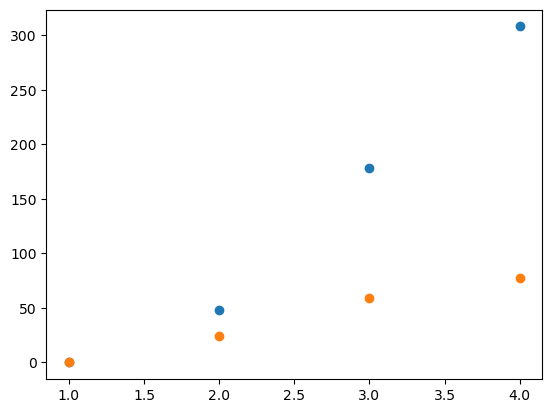

In [73]:
normalization = np.array([4, 3, 2, 1])
proteinCounts = np.array([len(r) for r in PDB.regions][:-1])
plt.scatter(normalization, proteinCounts)
plt.scatter(normalization, proteinCounts/normalization)

576 [308, 178, 48, 0, 42] [0.5347222222222222, 0.3090277777777778, 0.08333333333333333, 0.0, 0.07291666666666667]


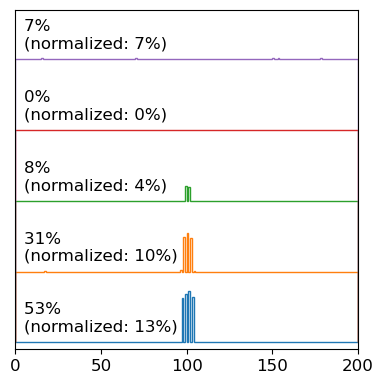

In [94]:
totProtein = np.sum([len(r) for r in PDB.regions])
print(totProtein, [len(r) for r in PDB.regions], [len(r)/totProtein for r in PDB.regions])
normalization = [4, 3, 2, 1, 1]

stepSize = 0.2

plt.rcParams['font.size']=12
plt.figure(figsize=(4,4))
for ir, r in enumerate(PDB.regions):
    hist, bin_edges = np.histogram(r, bins=np.arange(0,201,1))
    plt.stairs(hist/totProtein + stepSize*ir, bin_edges)
    plt.text(5, stepSize*ir+0.03, '%.0f%% \n(normalized: %.0f%%)'%(100*len(r)/totProtein, 
                                           100*len(r)/totProtein/normalization[ir]))
plt.xlim([0,200])
# plt.yticks(
#     np.array([0,1,2,3,4])*stepSize,
#     ['4 Targets', '3 Targets', '2 Targets', '1 Targets', 'In solution'],
# )
plt.yticks([])
plt.ylim([-stepSize*0.1, 4*stepSize+stepSize*0.7])
plt.tight_layout()
plt.show()

# Notes

4 proteins at 4 targets compared to 1 target...

4 times intensity of 4 targets compared to 1 target?
   - selection bias or selection pereference? Intensity / N

- Xiaona 2023's CUT data was from blood cells, but Fuda 2017's ChIP data was from lab cultured cells.
- CUT is more acurate and sensitive (S/N ratio higher)
- Sequencing results have fluctuations